Notwenige Importe

In [1]:
import sys
sys.path.append("src")  # Falls noch nicht gesetzt

from audio_data import AudioDataSet
from feature_set import FeatureSet
from drone_classifier import DroneClassifier

Konfigurationsfile

In [2]:
config = {
    "sample_rate": 16000,
    "audio_length": 1, # in Sekunden
    "train_path": "d:/Dropbox/03 H2 Think/AuDroK mFund/Auswertungen/Datensätze/Drone vs. No Drone/TRAINING/",
    "val_path":   "d:/Dropbox/03 H2 Think/AuDroK mFund/Auswertungen/Datensätze/Drone vs. No Drone/VALIDATION/",
    "model_file": "models/classifier_001.keras",
    "feature_files": {
        "train_features": "models/train_features.pkl",
        "val_features": "models/val_features.pkl",
        "train_labels": "models/train_labels.pkl",
        "val_labels": "models/val_labels.pkl"
    }
}

Rohdaten fürs Training laden und inspizieren

In [4]:
raw_data_train = AudioDataSet.from_path(
    path=config["train_path"],
    sample_rate=config["sample_rate"]
)

Processing audio files (3267 files to process):
[#######################################.] 99.45%


Apply Pre-Emphasis auf die Trainingsrohdaten

In [5]:
for audio in raw_data_train.audio:
    audio.apply_pre_emphasis()

Chunken der Trainingsrohdaten

In [6]:
chunk_length = config["sample_rate"] * config["audio_length"]
chunked_data_train = raw_data_train.chunk_all(chunk_length)
print(f"{len(chunked_data_train.audio)} Chunks")

39171 Chunks


Zwischenspeichern der Trainingsdaten zur Vereinfachung des Debuggings (kann später wieder entfernt werden)

In [7]:
# Speichern
import pickle

with open("chunked_data_train.pkl", "wb") as f:
    pickle.dump(chunked_data_train, f)

In [7]:
# Laden
import pickle

with open("chunked_data_train.pkl", "rb") as f:
    chunked_data_train = pickle.load(f)

Augmentieren der Chunks durch das Hinzufügen von Bodenreflexionen

In [8]:
from augmentations import apply_ground_reflection_to_dataset

ranges = {
    "src_x": (-10, 10),
    "src_y": (-10, 10),
    "src_z": (1, 5),
    "mic_z": (1, 2),
    "attenuation": (0.05, 0.95)
}

augmented_train_data = apply_ground_reflection_to_dataset(
    dataset=chunked_data_train,
    sample_rate=config["sample_rate"],
    ranges=ranges
)

Rohdaten für die Validierung laden

In [9]:
raw_data_val = AudioDataSet.from_path(
    path=config["val_path"],
    sample_rate=config["sample_rate"]
)

Processing audio files (277 files to process):
[####################################....] 92.42%


Apply Pre-Emphasis auf die Validierungsdaten

In [10]:
for audio in raw_data_val.audio:
    audio.apply_pre_emphasis()

Chunken der Validierungsdaten

In [11]:
chunk_length = config["sample_rate"] * config["audio_length"]
chunked_data_val = raw_data_val.chunk_all(chunk_length)
print(f"{len(chunked_data_val.audio)} Chunks")

34211 Chunks


Zwischenspeichern der Validierungsdaten zur Vereinfachung des Debuggings (kann später wieder entfernt werden)

In [12]:
# Speichern
import pickle

with open("chunked_data_val.pkl", "wb") as f:
    pickle.dump(chunked_data_val, f)

In [9]:
# Laden
import pickle

with open("chunked_data_val.pkl", "rb") as f:
    chunked_data_val = pickle.load(f)

Feature Extraction

In [10]:
# Feature-Extraktion
train_features = FeatureSet(augmented_train_data, sample_rate=config["sample_rate"])
X_train, y_train = train_features.extract()

val_features = FeatureSet(chunked_data_val, sample_rate=config["sample_rate"])
X_val, y_val = val_features.extract()

Processing features (39171 files to process):
[########################################] 100.00%
Processing features (34211 files to process):
[########################################] 100.00%


Zwischenspeichern der Features zur Vereinfachung des Debuggings (kann später wieder entfernt werden)

In [11]:
# Speichern
import pickle

with open("features.pkl", "wb") as f:
    pickle.dump({
        "X_train": X_train,
        "y_train": y_train,
        "X_val": X_val,
        "y_val": y_val
    }, f)

In [3]:
# Laden
import pickle

with open("features.pkl", "rb") as f:
    data = pickle.load(f)

X_train = data["X_train"]
y_train = data["y_train"]
X_val = data["X_val"]
y_val = data["y_val"]

Modelltraining & Evaluation

Encoded Labels - Train: [0 1]
Encoded Labels - Validation: [0 1]
Class weights: {0: np.float64(0.559138403562864), 1: np.float64(4.727371469949312)}
Epoch 1/30
613/613 ━━━━━━━━━━━━━━━━━━━━ 389s 625ms/step - accuracy: 0.8552 - loss: 1.4882 - val_accuracy: 0.7320 - val_loss: 0.1050 - learning_rate: 5.0000e-04
Epoch 2/30
613/613 ━━━━━━━━━━━━━━━━━━━━ 332s 542ms/step - accuracy: 0.9584 - loss: 0.0681 - val_accuracy: 0.6968 - val_loss: 0.0989 - learning_rate: 5.0000e-04
Epoch 3/30
613/613 ━━━━━━━━━━━━━━━━━━━━ 328s 535ms/step - accuracy: 0.9626 - loss: 0.0624 - val_accuracy: 0.6048 - val_loss: 0.1808 - learning_rate: 5.0000e-04
Epoch 4/30
613/613 ━━━━━━━━━━━━━━━━━━━━ 315s 514ms/step - accuracy: 0.9643 - loss: 0.0517 - val_accuracy: 0.5615 - val_loss: 0.1500 - learning_rate: 5.0000e-04
Epoch 5/30
613/613 ━━━━━━━━━━━━━━━━━━━━ 309s 504ms/step - accuracy: 0.9642 - loss: 0.0496 - val_accuracy: 0.5784 - val_loss: 0.1296 - learning_rate: 5.0000e-04
Epoch 6/30
613/613 ━━━━━━━━━━━━━━━━━━━━ 302s 493ms/

1070/1070 ━━━━━━━━━━━━━━━━━━━━ 108s 101ms/step
Erstellen eines Plots für die Konfusionsmatrix
Normalisierte Konfusionsmatrix (in Prozent):
[[67.11461067 32.88538933]
 [81.03264727 18.96735273]]
Anpassen der Achsenbeschriftung der Konfusionsmatrix
Speichern des Plots für die Konfusionsmatrix


TypeError: unsupported format string passed to NoneType.__format__

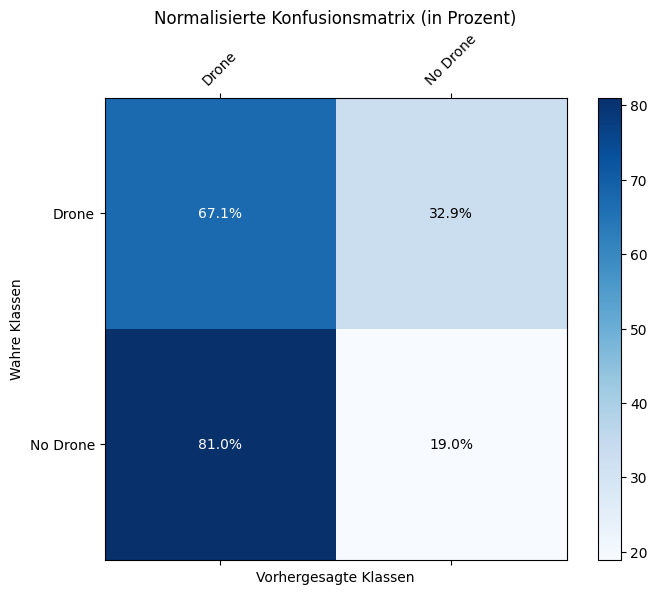

In [12]:
model = DroneClassifier(model_path="models/classifier_003.h5", trainable_layers=0)
model.train(X_train, y_train, X_val, y_val)
accuracy = model.evaluate(X_val, y_val)

print(f"Validierungsgenauigkeit: {accuracy:.2%}")

In [6]:
from drone_classifier import DroneClassifier
import inspect
print(inspect.signature(DroneClassifier.__init__))

(self, model_path, trainable_layers=0)


In [5]:
print(type(X_train), X_train.shape)
print(type(y_train), len(y_train))
print(type(X_val), X_val.shape)
print(type(y_val), len(y_val))

AttributeError: 'AudioDataSet' object has no attribute 'shape'